In [1]:
# DSP 461: Final Project Experiment 3
# Carly Carroll & Ryan Tsang 

In [56]:
##### LOAD LIBRARIES #####

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [57]:
##### LOAD AFFORDABILITY DATA INTO PYTHON #####

affordability = pd.read_csv("affordability.csv")

In [58]:
##### NEURAL NETWORK ANALYSIS #####

# Objective: Predict affordability scores and migration patterns while also uncovering the relationships between them
# Key Questions: 
    # How accuractly can a neural network predict affordability scores based on different variables?
    # How effectively can a neural network classify migration patterns and which variables contribute most to accurate predictions?
    # What insights can be gained from feature selection and partial dependence plots about the relationships between affordability and migration trends?

In [59]:
### predicting affordability scores ###

# removing duplicates from the dataset for unique RegionName and StateName
affordability = affordability.drop_duplicates(subset=['RegionName', 'StateName'])

# define features and target
features = ['HousingCostAvg', 'TotalLivingCost', 'median_family_income', 'TotalPop', 'crime_rate_per_100000']
X = affordability[features]
y = affordability['AffordabilityScore']

# split and scale the data
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# define and train the neural network with improved hyperparameters
mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(64, 32),  
    activation='relu', 
    solver='adam', 
    random_state=42, 
    max_iter=2000, 
    learning_rate_init=0.00005, 
    alpha=0.001,
    verbose=False
)
mlp_regressor.fit(X_train_scaled, y_train)

# evaluate the model
y_pred = mlp_regressor.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Regression - Test MAE: {mae:.2f}, Test R²: {r2:.2f}")

Regression - Test MAE: 0.14, Test R²: -14.24


Classification Report for Migration Prediction:
              precision    recall  f1-score   support

    Net Gain       0.59      0.96      0.73       112
    Net Loss       0.67      0.10      0.17        83

    accuracy                           0.59       195
   macro avg       0.63      0.53      0.45       195
weighted avg       0.62      0.59      0.49       195



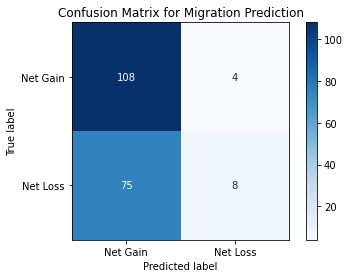

In [60]:
### classification for migration ###

# define migration classes
if 'MigrationClass' not in affordability.columns:
    affordability['MigrationClass'] = pd.cut(
        affordability['NET in'], bins=[-float('inf'), -1, 1, float('inf')], labels=["Net Loss", "Neutral", "Net Gain"]
    )

# define features and target
features_migration = ['INflow', 'OUTflow', 'TotalPop', 'HousingCostAvg', 'median_family_income']
X_migration = affordability[features_migration]
y_migration = affordability['MigrationClass']

# define the target variable as numerical values
label_encoder = LabelEncoder()
y_migration_encoded = label_encoder.fit_transform(y_migration)

# split and scale the data
X_train_mig, X_test_mig, y_train_mig, y_test_mig = train_test_split(X_migration, y_migration_encoded, test_size=0.3, random_state=42)
X_train_mig_scaled = scaler.fit_transform(X_train_mig)
X_test_mig_scaled = scaler.transform(X_test_mig)

# define and train the neural network
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    random_state=42,
    max_iter=2000,  
    learning_rate_init=0.00005,  
    alpha=0.0005 
)
mlp_classifier.fit(X_train_mig_scaled, y_train_mig)

# evaluate the model
y_pred_mig = mlp_classifier.predict(X_test_mig_scaled)
print("Classification Report for Migration Prediction:")
print(classification_report(y_test_mig, y_pred_mig, target_names=label_encoder.classes_))

confusion_matrix_display = ConfusionMatrixDisplay.from_estimator(
    mlp_classifier,
    X_test_mig_scaled,
    y_test_mig,
    display_labels=label_encoder.classes_,
    cmap='Blues' 
)
plt.title("Confusion Matrix for Migration Prediction")
plt.show()

In [61]:
### feature selection with recursive feature elimination

# regression: feature selection for affordability prediction
regressor = LinearRegression()
rfe_reg = RFE(regressor, n_features_to_select=5) 
rfe_reg.fit(X, y) 

print("Selected Features for Affordability Regression:")
for feature, support in zip(features, rfe_reg.support_):
    if support:
        print(feature)

# classification: feature selection for migration prediction
classifier = RandomForestClassifier(random_state=42)
rfe_class = RFE(classifier, n_features_to_select=5)  
rfe_class.fit(X_migration, y_migration) 

print("Selected Features for Migration Classification:")
for feature, support in zip(features_migration, rfe_class.support_):
    if support:
        print(feature)
        
# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_migration_scaled = scaler.fit_transform(X_migration)

# define the migration classes
label_encoder = LabelEncoder()
y_migration_encoded = label_encoder.fit_transform(y_migration)

Selected Features for Affordability Regression:
HousingCostAvg
TotalLivingCost
median_family_income
TotalPop
crime_rate_per_100000
Selected Features for Migration Classification:
INflow
OUTflow
TotalPop
HousingCostAvg
median_family_income


In [62]:
### cross validation with neural networks ###

# regression: cross validation for affordability prediction
mlp_regressor = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    max_iter=3000, 
    random_state=42,
    learning_rate_init=0.0001, 
    alpha=0.0001,
    verbose=False 
)
reg_scores = cross_val_score(mlp_regressor, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-Validation MAE for Affordability Prediction: {-reg_scores.mean():.3f}")

# classification: cross validation for migration prediction
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=3000,
    random_state=42,
    learning_rate_init=0.0001,
    alpha=0.0001,
    verbose=False 
)
class_scores = cross_val_score(mlp_classifier, X_migration_scaled, y_migration_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy for Migration Classification: {class_scores.mean():.3f}")


Cross-Validation MAE for Affordability Prediction: 0.098
Cross-Validation Accuracy for Migration Classification: 0.892


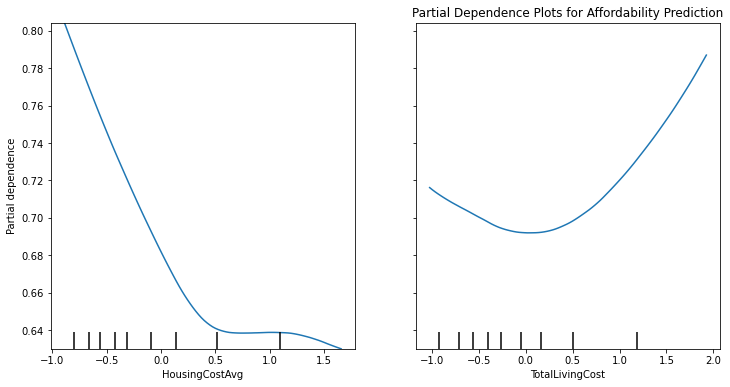

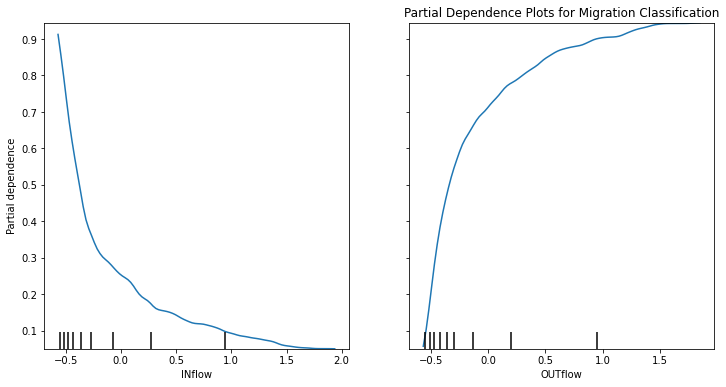

In [63]:
### partial dependence plots ###

# fefine feature names to be used for PDP
selected_features = [0, 1] 

# train the model and plot PDP for affordability regression
mlp_regressor.set_params(verbose=False, max_iter=5000) 
mlp_regressor.fit(X_train_scaled, y_train)
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    mlp_regressor,
    X_train_scaled,
    features=selected_features,
    feature_names=features, 
    ax=ax,
)
plt.title("Partial Dependence Plots for Affordability Prediction")
plt.show()

# train the model and plot PDP for migration classification
selected_features_class = [0, 1] 
mlp_classifier.set_params(verbose=False, max_iter=5000)  # Increase iterations and suppress verbose logs
mlp_classifier.fit(X_train_mig_scaled, y_train_mig)
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(
    mlp_classifier,
    X_train_mig_scaled,
    features=selected_features_class,
    feature_names=features_migration,  
    ax=ax,
)
plt.title("Partial Dependence Plots for Migration Classification")
plt.show()